<a href="https://colab.research.google.com/github/caballerofelipe/Structuring-data-to-answer-a-question-an-example/blob/main/Structuring_data_to_answer_a_question%2C_an_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structuring data to answer a question, an example

When having an idea about how to use some data, you might need to structure it in some way that will allow you to answer a specific question. In this specific example, we're going to use stock data, from the Santiago Stock Exchange.

In this example the question we want to answer is:

> "Buying at high of day 5 (knowing previous 4 days data), will there be an increase in 5% in the following 15 days for any of the the daily low values?"

So the question we want to answer (and for which we are preparing the data) is:
- If we buy on a given day at a high point (potentially expensive price).
- We want to sell in the next 15.
- We want to sell as soon as the price gets to a 5% increase (this could be set up as a trigger).
- We want to create a column that will tell us if the price will increase 5% in the next 15 days, for this we will use the low value of the next 15 days. If any of the lows from the next 15 days gets to that 5% increase we want to have a column that says so (using True for yes and False for no).
- We want to use the data from 4 previous days to predict if we will be able to sell at 5% increase in the next 15 days.

At this point we don't care if this is a good idea or not. In the future we might want to work on different models to test this idea, right now we care about preparing the data.

>[Structuring data to answer a question, an example](#scrollTo=TiP34yjU6TI1)

>>[Initial config (Colab or Local)](#scrollTo=zTYn2wM3SpXg)

>>[Import stuff](#scrollTo=6CvLhneQSlZw)

>>[Data](#scrollTo=vOrZNgyES7n2)

>>>[Data import](#scrollTo=2OSHZa446TI_)

>>>[Data exploration](#scrollTo=Bre-Vj8F6TJB)

>>>>[This is what the imported data looks like](#scrollTo=oKHHrada6TJB)

>>>>[The nemos](#scrollTo=3XZ-JK-i6TJC)

>>[Preparing our data](#scrollTo=c6-oWGjm6TJG)

>>>[Implement 2 days per row with for 2 nemos](#scrollTo=Vrc4NsTQ6TJH)

>>>[Create a DataFrame where each row contains 20 days](#scrollTo=JVwfK0pb6TJJ)

>>>>[Seeing some results](#scrollTo=HpwyCr1F6TJK)

>>>>[Showing results for a given row to compare to the actual data](#scrollTo=1x27ICme6TJL)

>>[Adding a column to the DataFrame that allows us to explain the initial question: "Buying at high of day 5 (knowing previous 4 days data), will there be an increase in 5% in the following 15 days for any of the the daily low values?"](#scrollTo=ylg5nBpw6TJM)

>>>[Reload data from file to avoid to run everything above](#scrollTo=FkGPbNH26TJM)

>>>[Use query to see the data only for the last day](#scrollTo=4z2YpDHw6TJN)

>>>[Use eval to create a selection series only for the last day](#scrollTo=raGj4aKg6TJN)

>>>[Our experiments above worked, let's implement for the complete dataset](#scrollTo=AsQMJ7Tn6TJN)

>>>[Let's create the new column that answers our question for each row](#scrollTo=czFGMK9_6TJP)

>>[Conclusion](#scrollTo=5DkXrJ-56TJR)



## Initial config (Colab or Local)

Let's set these variables to make our life easier:
- BASE_PATH: The current working directory.
- NOTEBOOK_DIR: The directory where the working Notebook is located.

Also, for Colab I like creating a sym link (see the NOTEBOOK_DIR part below with the `ln` ) so that the directory where the notebook is located is easily accessible from the `/content` dir. I like using one folder per project so that I only see the relevant files in there.

In [1]:
try:  # Mount Google Drive
    import os

    from google.colab import drive

    drive.mount("/content/gdrive")
    
    # https://stackoverflow.com/a/63413053
    import os
    path = "/content" # /content is pretty much the root. you can choose other path in your colab workspace
    os.chdir(path)

    BASE_PATH = !pwd
    BASE_PATH = BASE_PATH[0]

    NOTEBOOK_DIR = "/content/gdrive/My Drive/2022-09 bolsaInfo"
    bolsaInfo_csv = f"{NOTEBOOK_DIR}/igpaHistorical.csv"
    
    # NOTEBOOK_DIR is a link to where the notebook is located so that we can access the directory
    #   easily and fast
    !if [ -e NOTEBOOK_DIR ]; then echo 'NOTEBOOK_DIR link already exists'; else ln -s "{NOTEBOOK_DIR}" NOTEBOOK_DIR; fi

except:  # Locally run Jupyter
    # WARNING NOT TESTED LOCALLY, might not work
    BASE_PATH = !pwd
    BASE_PATH = BASE_PATH[0]
    
    NOTEBOOK_DIR = f"{BASE_PATH}"

bolsaInfo_csv = f"{NOTEBOOK_DIR}/igpaHistorical.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
NOTEBOOK_DIR link already exists


## Import stuff

In [2]:
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Data

### Data import

Let's import the CSV with the stock data.

In [3]:
# We'll use all columns except id
df = pd.read_csv(bolsaInfo_csv, usecols=[
                 'nemo', 'fecha', 'open', 'high', 'low', 'close', 'volume'])
df.head(2)


,nemo,fecha,open,high,low,close,volume
0,AESGENER,2007-02-14 00:00:00,229.5310,237.2464,231.4598,231.537,7667639
1,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.531,2384857


### Data exploration

Before doing some processing, let's play a bit with our data.

#### This is what the imported data looks like

In [4]:
df


,nemo,fecha,open,high,low,close,volume
0,AESGENER,2007-02-14 00:00:00,229.5310,237.2464,231.4598,231.5370,7667639
1,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.5310,2384857
2,AESGENER,2007-02-16 00:00:00,229.5311,237.2464,230.4955,234.3532,3409814
3,AESGENER,2007-02-19 00:00:00,234.3532,234.3532,230.4955,230.4955,76903
4,AESGENER,2007-02-20 00:00:00,230.4955,226.6379,219.8869,224.7090,3811969
...,...,...,...,...,...,...,...
198225,SOCOVESA,2019-06-17 00:00:00,370.0000,359.7800,359.7800,370.0000,5651
198226,SONDA,2019-06-17 00:00:00,936.0000,937.0000,928.0000,928.4100,85775
198227,SQM-B,2019-06-17 00:00:00,21873.0000,22200.0000,21729.0000,22012.0000,145468
198228,VAPORES,2019-06-17 00:00:00,21.4000,21.7900,21.0200,21.4800,19572770


#### The nemos

Let's see how many nemos there are?

In [5]:
len(df['nemo'].unique())


86

Let's see the unique nemos and how many rows there are per nemo.

In [6]:
# Let's use a dict to see more information here
dict(df['nemo'].value_counts())


{'AESGENER': 3072,
 'CHILE': 3072,
 'RIPLEY': 3072,
 'FALABELLA': 3072,
 'ENTEL': 3072,
 'SQM-B': 3072,
 'COPEC': 3072,
 'ITAUCORP': 3072,
 'CMPC': 3072,
 'COLBUN': 3072,
 'CENCOSUD': 3072,
 'CCU': 3072,
 'CAP': 3072,
 'BSANTANDER': 3072,
 'VAPORES': 3072,
 'CONCHATORO': 3071,
 'ECL': 3071,
 'BCI': 3071,
 'IAM': 3071,
 'ANDINA-B': 3070,
 'SONDA': 3069,
 'SALFACORP': 3059,
 'PARAUCO': 3058,
 'ENELAM': 3057,
 'ENELGXCH': 3057,
 'NUEVAPOLAR': 3046,
 'ANTARCHILE': 3041,
 'SM-CHILE B': 3024,
 'MASISA': 3019,
 'AGUAS-A': 3015,
 'SK': 2959,
 'FORUS': 2958,
 'SECURITY': 2901,
 'MULTIFOODS': 2898,
 'QUINENCO': 2892,
 'BESALCO': 2858,
 'HABITAT': 2817,
 'COLO COLO': 2790,
 'ALMENDRAL': 2770,
 'PAZ': 2729,
 'SOCOVESA': 2712,
 'BANMEDICA': 2700,
 'ORO BLANCO': 2695,
 'NORTEGRAN': 2684,
 'LAN': 2554,
 'GASCO': 2536,
 'ANDINA-A': 2525,
 'INVERCAP': 2494,
 'ZOFRI': 2479,
 'PEHUENCHE': 2473,
 'EMBONOR-B': 2468,
 'INVERMAR': 2417,
 'VSPT': 2338,
 'INDISA': 2273,
 'ENJOY': 2266,
 'HITES': 2237,
 'LAS CO

Let's see if describe() gives us some interesting information.

In [7]:
df.describe()


,open,high,low,close,volume
count,198230.000000,198230.000000,198230.000000,198230.000000,1.982300e+05
mean,2959.889508,2985.464668,2934.894535,2959.840397,1.185071e+07
std,6223.282224,6274.423161,6173.052607,6223.323547,1.495861e+08
min,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,152.119850,153.432500,150.500000,152.119800,3.931625e+04
50%,650.000000,652.000000,645.000000,650.000000,3.118155e+05
75%,2390.000000,2400.100000,2365.000000,2390.000000,1.704520e+06
max,47198.000000,48000.000000,46658.000000,47198.000000,2.333623e+10


Apparently there's nothing too crazy in there. We do see that all columns have the same number or counts so the data is complete.

Let's print the data for just one nemo to see if everything looks alright.

In [8]:
df[df['nemo'] == 'AESGENER']


,nemo,fecha,open,high,low,close,volume
0,AESGENER,2007-02-14 00:00:00,229.5310,237.2464,231.4598,231.5370,7667639
1,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.5310,2384857
2,AESGENER,2007-02-16 00:00:00,229.5311,237.2464,230.4955,234.3532,3409814
3,AESGENER,2007-02-19 00:00:00,234.3532,234.3532,230.4955,230.4955,76903
4,AESGENER,2007-02-20 00:00:00,230.4955,226.6379,219.8869,224.7090,3811969
...,...,...,...,...,...,...,...
197928,AESGENER,2019-06-11 00:00:00,181.0000,186.9000,181.0000,185.0500,2856948
197990,AESGENER,2019-06-12 00:00:00,185.0500,186.7700,184.1100,184.8700,1547088
198049,AESGENER,2019-06-13 00:00:00,184.8700,186.9500,184.2000,184.5000,2870620
198113,AESGENER,2019-06-14 00:00:00,184.5000,184.5500,181.3000,181.4100,1940961


Let's print a couple of nemo's closing price to see if the data looks ok.

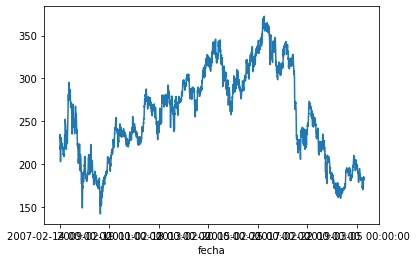

In [9]:
df[df['nemo'] == 'AESGENER'].set_index('fecha')['close'].plot()


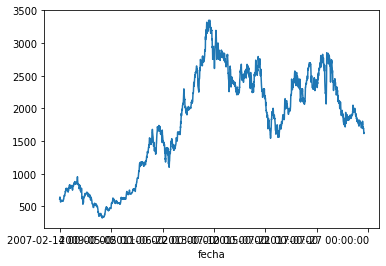

In [10]:
df[df['nemo'] == 'FORUS'].set_index('fecha')['close'].plot()


## Preparing our data

Right now, in our DataFrame we have the following fields in each row:
- nemo
- fecha (date in spanish)
- open
- high
- low
- close
- volume

That's 7 colums. 

So if we want to have the data for 4 prior days and 15 days after the given day for each, we would need the data above plus also 4 days before and 15 days after. That means we need 7 * 20 colums, where 20 is the total amount of days.

We don't need to have nemo duplicated but we could use that as a verification method.


### Implement 2 days per row with for 2 nemos

Before creating a full implementation for all nemos and our complete dataset, let's see if we can do it with just two nemos:
> Joining multiple days in one row for two given nemos, then joining the results in one DataFrame.

In [11]:
# Store resulting dataframes by nemo
#   nemo_dict['nemo'] is a DataFrame containing the data for 'nemo'
nemo_dict = {}


In [12]:
nemo = 'AESGENER'

# Created 2 dataframes, the first one is all, the second one is shifted by one, so:
#   - The second one has the same data except for the first row (from all data)
#   - The first row from the second one is the second row from the first one
dfL = df[df['nemo'] == nemo][0:].reset_index()  # .head(2)
dfR = df[df['nemo'] == nemo][1:].reset_index()  # .head(2)

# We join both dataframes so for the new dataframe we see on row 1
#   the first row of the first one and the first row of the second one
nemo_dict[nemo] = dfL.join(dfR, lsuffix='_1', rsuffix='_2')
nemo_dict[nemo].head(2)


,index_1,nemo_1,fecha_1,open_1,high_1,low_1,close_1,volume_1,index_2,nemo_2,fecha_2,open_2,high_2,low_2,close_2,volume_2
0,0,AESGENER,2007-02-14 00:00:00,229.5310,237.2464,231.4598,231.537,7667639,1.0,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.5310,2384857.0
1,1,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.531,2384857,2.0,AESGENER,2007-02-16 00:00:00,229.5311,237.2464,230.4955,234.3532,3409814.0


That test works, we see two days in each row for AESGENER!

Let's try again with another nemo.

In [13]:
# See comments above
nemo = 'FORUS'

dfL = df[df['nemo'] == nemo][0:].reset_index()  # .head(2)
dfR = df[df['nemo'] == nemo][1:].reset_index()  # .head(2)

nemo_dict[nemo] = dfL.join(dfR, lsuffix='_1', rsuffix='_2')
nemo_dict[nemo].head(2)


,index_1,nemo_1,fecha_1,open_1,high_1,low_1,close_1,volume_1,index_2,nemo_2,fecha_2,open_2,high_2,low_2,close_2,volume_2
0,46702,FORUS,2007-02-14 00:00:00,612.0,620.0,611.0,615.1,413696,46703.0,FORUS,2007-02-15 00:00:00,615.1,625.0,620.0,621.9,88271.0
1,46703,FORUS,2007-02-15 00:00:00,615.1,625.0,620.0,621.9,88271,46704.0,FORUS,2007-02-16 00:00:00,621.9,636.0,628.5,635.0,610354.0


Now that we have a dictionary with two different nemos with data from 2 days per row, let's try and put those two nemo's DataFrames in one single DataFrame.

In [14]:
# Create a new DataFrame using the ones created in the cells above
pd.concat([nemo_dict['AESGENER'], nemo_dict['FORUS']], ignore_index=True)

# # There's another way of doing the line above but it might become deprecated
# nemo_dict['AESGENER'].append(nemo_dict['FORUS'])


,index_1,nemo_1,fecha_1,open_1,high_1,low_1,close_1,volume_1,index_2,nemo_2,fecha_2,open_2,high_2,low_2,close_2,volume_2
0,0,AESGENER,2007-02-14 00:00:00,229.5310,237.2464,231.4598,231.5370,7667639,1.0,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.5310,2384857.0
1,1,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.5310,2384857,2.0,AESGENER,2007-02-16 00:00:00,229.5311,237.2464,230.4955,234.3532,3409814.0
2,2,AESGENER,2007-02-16 00:00:00,229.5311,237.2464,230.4955,234.3532,3409814,3.0,AESGENER,2007-02-19 00:00:00,234.3532,234.3532,230.4955,230.4955,76903.0
3,3,AESGENER,2007-02-19 00:00:00,234.3532,234.3532,230.4955,230.4955,76903,4.0,AESGENER,2007-02-20 00:00:00,230.4955,226.6379,219.8869,224.7090,3811969.0
4,4,AESGENER,2007-02-20 00:00:00,230.4955,226.6379,219.8869,224.7090,3811969,5.0,AESGENER,2007-02-21 00:00:00,224.7089,221.8157,212.1716,216.9743,2637298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025,197958,FORUS,2019-06-11 00:00:00,1700.0000,1700.0000,1680.0000,1691.1000,13279,198015.0,FORUS,2019-06-12 00:00:00,1691.1000,1680.0000,1645.2000,1649.8000,119756.0
6026,198015,FORUS,2019-06-12 00:00:00,1691.1000,1680.0000,1645.2000,1649.8000,119756,198082.0,FORUS,2019-06-13 00:00:00,1649.8000,1699.9000,1645.0000,1645.0000,11349.0
6027,198082,FORUS,2019-06-13 00:00:00,1649.8000,1699.9000,1645.0000,1645.0000,11349,198141.0,FORUS,2019-06-14 00:00:00,1645.0000,1645.0000,1600.0000,1616.0000,40103.0
6028,198141,FORUS,2019-06-14 00:00:00,1645.0000,1645.0000,1600.0000,1616.0000,40103,198200.0,FORUS,2019-06-17 00:00:00,1616.0000,1630.0000,1620.0000,1629.0000,23572.0


That works!

### Create a DataFrame where each row contains 20 days

Now that we know how to implement our idea, let's do it for the full 20 days length we planned in the beginning. Let's put everything together.

In [15]:
def df_days_in_row(df: pd.DataFrame, days_num: int = 20) -> pd.DataFrame:
    '''
    Create a DataFrame where each row contains days_num days

        Parameters
        ----------
            days_num: The number of days in one row

    '''
    # Start with an empy DataFrame
    df_new = pd.DataFrame()

    for nemo in df['nemo'].unique():  # For every nemo

        # DataFrame to store temporarily shifted versions of the data for a given nemo
        _shiffted_df_list = []

        # Create given number of DataFrames for a given nemo (given number set by days_num)
        for i in range(days_num):
            _shiffted_df_list.append(
                df[df['nemo'] == nemo][i:].reset_index().add_suffix(f'_{i}'))

            # # One liner above does the same as below, what's shown below is for explanation purposes
            # _df = df[df['nemo']==nemo][i:] # Select from index to the end
            # _df.reset_index(inplace=True) # Reset the index to start counting from 0 for all indexed DataFrames
            # _df = _df.add_suffix(f'_{i}') # Add a suffix to avoid confusions
            # _shiffted_df_list.append( _df ) # Append the resulting DataFrame to the list

            #print(f'_shiffted_df_list {i}')

        # Add the same indexes as the DataFrames created above
        _tmp_df = pd.DataFrame()
        _tmp_df.index = _shiffted_df_list[0].index
        # break

        # Join horizontally all DataFrames created above
        for i in range(days_num):
            _tmp_df = _tmp_df.join(_shiffted_df_list[i])
            #print(f'_tmp_df {i}')

        # Remove the days that don't include all the days in the columns
        _tmp_df = _tmp_df[:-days_num]

        # Add the current DataFrame (_tmp_df) to the final result
        # Deprecated: `df_new.append(_tmp_df)`
        df_new = pd.concat([df_new, _tmp_df])
        # break

    return df_new


In [16]:
days = 20

df_20days = df_days_in_row(df=df, days_num=days)
df_20days.to_csv(f"{NOTEBOOK_DIR}/igpaHistorical_{days}days.csv")
df_20days


,index_0,nemo_0,fecha_0,open_0,high_0,low_0,close_0,volume_0,index_1,nemo_1,...,close_18,volume_18,index_19,nemo_19,fecha_19,open_19,high_19,low_19,close_19,volume_19
0,0,AESGENER,2007-02-14 00:00:00,229.5310,237.2464,231.4598,231.5370,7667639,1.0,AESGENER,...,227.6022,5966929.0,19.0,AESGENER,2007-03-13 00:00:00,227.6022,226.6379,216.0292,221.8157,3346205.0
1,1,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.5310,2384857,2.0,AESGENER,...,221.8157,3346205.0,20.0,AESGENER,2007-03-14 00:00:00,221.8157,221.7193,217.9484,218.9128,4533820.0
2,2,AESGENER,2007-02-16 00:00:00,229.5311,237.2464,230.4955,234.3532,3409814,3.0,AESGENER,...,218.9128,4533820.0,21.0,AESGENER,2007-03-15 00:00:00,218.9129,221.8157,218.9225,219.4626,2961416.0
3,3,AESGENER,2007-02-19 00:00:00,234.3532,234.3532,230.4955,230.4955,76903,4.0,AESGENER,...,219.4626,2961416.0,22.0,AESGENER,2007-03-16 00:00:00,219.4625,219.4626,217.9580,218.4402,2004309.0
4,4,AESGENER,2007-02-20 00:00:00,230.4955,226.6379,219.8869,224.7090,3811969,5.0,AESGENER,...,218.4402,2004309.0,23.0,AESGENER,2007-03-19 00:00:00,218.4402,223.7445,218.4306,223.7445,7737954.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,196719,LTM,2019-05-13 00:00:00,6629.0000,6498.0000,6210.0000,6292.0000,564247,196779.0,LTM,...,6339.4000,226931.0,197908.0,LTM,2019-06-10 00:00:00,6339.4000,6539.9000,6385.0000,6440.0000,180730.0
381,196779,LTM,2019-05-14 00:00:00,6292.0000,6384.9000,6305.0000,6315.0000,794808,196845.0,LTM,...,6440.0000,180730.0,197968.0,LTM,2019-06-11 00:00:00,6440.0000,6510.0000,6400.0000,6400.0000,837655.0
382,196845,LTM,2019-05-15 00:00:00,6315.0000,6397.9000,6221.0000,6274.3000,697094,196911.0,LTM,...,6400.0000,837655.0,198027.0,LTM,2019-06-12 00:00:00,6400.0000,6500.0000,6362.6000,6363.0000,733319.0
383,196911,LTM,2019-05-16 00:00:00,6274.3000,6280.0000,6105.0000,6130.0000,490016,196973.0,LTM,...,6363.0000,733319.0,198091.0,LTM,2019-06-13 00:00:00,6363.0000,6499.9000,6370.0000,6420.0000,341964.0


#### Seeing some results

Let's see some results to see if what we did above worked as expected.

In the following cell, we'll see only nemo, each index and each date for every day. That way the dates should increase just as the index.

In [17]:
days = 20
indexes = ['nemo_0']
for i in range(days):
    indexes.append(f'index_{i}')
    indexes.append(f'fecha_{i}')
# list(df_20days.columns)
df_20days[indexes]


,nemo_0,index_0,fecha_0,index_1,fecha_1,index_2,fecha_2,index_3,fecha_3,index_4,...,index_15,fecha_15,index_16,fecha_16,index_17,fecha_17,index_18,fecha_18,index_19,fecha_19
0,AESGENER,0,2007-02-14 00:00:00,1.0,2007-02-15 00:00:00,2.0,2007-02-16 00:00:00,3.0,2007-02-19 00:00:00,4.0,...,15.0,2007-03-07 00:00:00,16.0,2007-03-08 00:00:00,17.0,2007-03-09 00:00:00,18.0,2007-03-12 00:00:00,19.0,2007-03-13 00:00:00
1,AESGENER,1,2007-02-15 00:00:00,2.0,2007-02-16 00:00:00,3.0,2007-02-19 00:00:00,4.0,2007-02-20 00:00:00,5.0,...,16.0,2007-03-08 00:00:00,17.0,2007-03-09 00:00:00,18.0,2007-03-12 00:00:00,19.0,2007-03-13 00:00:00,20.0,2007-03-14 00:00:00
2,AESGENER,2,2007-02-16 00:00:00,3.0,2007-02-19 00:00:00,4.0,2007-02-20 00:00:00,5.0,2007-02-21 00:00:00,6.0,...,17.0,2007-03-09 00:00:00,18.0,2007-03-12 00:00:00,19.0,2007-03-13 00:00:00,20.0,2007-03-14 00:00:00,21.0,2007-03-15 00:00:00
3,AESGENER,3,2007-02-19 00:00:00,4.0,2007-02-20 00:00:00,5.0,2007-02-21 00:00:00,6.0,2007-02-22 00:00:00,7.0,...,18.0,2007-03-12 00:00:00,19.0,2007-03-13 00:00:00,20.0,2007-03-14 00:00:00,21.0,2007-03-15 00:00:00,22.0,2007-03-16 00:00:00
4,AESGENER,4,2007-02-20 00:00:00,5.0,2007-02-21 00:00:00,6.0,2007-02-22 00:00:00,7.0,2007-02-23 00:00:00,8.0,...,19.0,2007-03-13 00:00:00,20.0,2007-03-14 00:00:00,21.0,2007-03-15 00:00:00,22.0,2007-03-16 00:00:00,23.0,2007-03-19 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,LTM,196719,2019-05-13 00:00:00,196779.0,2019-05-14 00:00:00,196845.0,2019-05-15 00:00:00,196911.0,2019-05-16 00:00:00,196973.0,...,197668.0,2019-06-04 00:00:00,197727.0,2019-06-05 00:00:00,197783.0,2019-06-06 00:00:00,197844.0,2019-06-07 00:00:00,197908.0,2019-06-10 00:00:00
381,LTM,196779,2019-05-14 00:00:00,196845.0,2019-05-15 00:00:00,196911.0,2019-05-16 00:00:00,196973.0,2019-05-17 00:00:00,197035.0,...,197727.0,2019-06-05 00:00:00,197783.0,2019-06-06 00:00:00,197844.0,2019-06-07 00:00:00,197908.0,2019-06-10 00:00:00,197968.0,2019-06-11 00:00:00
382,LTM,196845,2019-05-15 00:00:00,196911.0,2019-05-16 00:00:00,196973.0,2019-05-17 00:00:00,197035.0,2019-05-20 00:00:00,197098.0,...,197783.0,2019-06-06 00:00:00,197844.0,2019-06-07 00:00:00,197908.0,2019-06-10 00:00:00,197968.0,2019-06-11 00:00:00,198027.0,2019-06-12 00:00:00
383,LTM,196911,2019-05-16 00:00:00,196973.0,2019-05-17 00:00:00,197035.0,2019-05-20 00:00:00,197098.0,2019-05-22 00:00:00,197157.0,...,197844.0,2019-06-07 00:00:00,197908.0,2019-06-10 00:00:00,197968.0,2019-06-11 00:00:00,198027.0,2019-06-12 00:00:00,198091.0,2019-06-13 00:00:00


#### Showing results for a given row to compare to the actual data

Now, let's verify some numbers.

Let's compare the data from what we created and the original data. It should display the same thing.

In [18]:
# Let's print one line from our generated data
_ = dict(df_20days.sample(1).iloc[0])
_


{'index_0': 173512,
 'nemo_0': 'ENJOY',
 'fecha_0': '2017-12-21 00:00:00',
 'open_0': 56.0,
 'high_0': 55.16,
 'low_0': 54.98,
 'close_0': 55.0,
 'volume_0': 2615938,
 'index_1': 173589.0,
 'nemo_1': 'ENJOY',
 'fecha_1': '2017-12-22 00:00:00',
 'open_1': 55.0,
 'high_1': 55.0,
 'low_1': 55.0,
 'close_1': 55.0,
 'volume_1': 3675542.0,
 'index_2': 173662.0,
 'nemo_2': 'ENJOY',
 'fecha_2': '2017-12-26 00:00:00',
 'open_2': 55.0,
 'high_2': 56.0,
 'low_2': 54.0,
 'close_2': 54.0,
 'volume_2': 605409.0,
 'index_3': 173737.0,
 'nemo_3': 'ENJOY',
 'fecha_3': '2017-12-27 00:00:00',
 'open_3': 55.87,
 'high_3': 55.87,
 'low_3': 54.0,
 'close_3': 54.0,
 'volume_3': 957637.0,
 'index_4': 173816.0,
 'nemo_4': 'ENJOY',
 'fecha_4': '2017-12-28 00:00:00',
 'open_4': 54.0,
 'high_4': 55.0,
 'low_4': 52.5,
 'close_4': 53.0,
 'volume_4': 31246780.0,
 'index_5': 173888.0,
 'nemo_5': 'ENJOY',
 'fecha_5': '2017-12-29 00:00:00',
 'open_5': 53.0,
 'high_5': 53.5,
 'low_5': 53.01,
 'close_5': 53.4,
 'volume_5

In [19]:
# Let's print 20 rows using the nemo selected above and printing its next 19 rows
_pos = _['index_0']
print(_pos)
_nemo = _['nemo_0']
print(_nemo)

df[df['nemo'] == _nemo].loc[_pos:(_pos+19)]


173512
ENJOY


,nemo,fecha,open,high,low,close,volume
173512,ENJOY,2017-12-21 00:00:00,56.0,55.16,54.98,55.0,2615938


↑ The above results appear to be correct.

## Adding a column to the DataFrame that allows us to explain the initial question: "Buying at high of day 5 (knowing previous 4 days data), will there be an increase in 5% in the following 15 days for any of the the daily low values?"

### Reload data from file to avoid to run everything above

In [20]:
days = 20
df_20days = pd.read_csv(
    f"{NOTEBOOK_DIR}/igpaHistorical_{days}days.csv", index_col=0)
df_20days.head(2)


,index_0,nemo_0,fecha_0,open_0,high_0,low_0,close_0,volume_0,index_1,nemo_1,...,close_18,volume_18,index_19,nemo_19,fecha_19,open_19,high_19,low_19,close_19,volume_19
0,0,AESGENER,2007-02-14 00:00:00,229.5310,237.2464,231.4598,231.537,7667639,1.0,AESGENER,...,227.6022,5966929.0,19.0,AESGENER,2007-03-13 00:00:00,227.6022,226.6379,216.0292,221.8157,3346205.0
1,1,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.531,2384857,2.0,AESGENER,...,221.8157,3346205.0,20.0,AESGENER,2007-03-14 00:00:00,221.8157,221.7193,217.9484,218.9128,4533820.0


### Use query to see the data only for the last day

In [21]:
df_20days.query('high_4 * 1.05 <= low_19')


,index_0,nemo_0,fecha_0,open_0,high_0,low_0,close_0,volume_0,index_1,nemo_1,...,close_18,volume_18,index_19,nemo_19,fecha_19,open_19,high_19,low_19,close_19,volume_19
5,5,AESGENER,2007-02-21 00:00:00,224.7089,221.8157,212.1716,216.9743,2637298,6.0,AESGENER,...,223.7445,7737954.0,24.0,AESGENER,2007-03-20 00:00:00,223.7445,223.7445,220.7548,221.8157,2812159.0
33,33,AESGENER,2007-04-02 00:00:00,218.9225,218.9225,216.5114,216.9937,2037925,34.0,AESGENER,...,233.3887,3751976.0,52.0,AESGENER,2007-04-30 00:00:00,233.3888,233.3887,229.0488,229.6276,2984114.0
34,34,AESGENER,2007-04-03 00:00:00,216.9936,216.9937,212.3644,216.0292,3264155,35.0,AESGENER,...,229.6276,2984114.0,53.0,AESGENER,2007-05-02 00:00:00,229.6275,231.4598,229.6276,230.4955,1804634.0
35,35,AESGENER,2007-04-04 00:00:00,216.0292,216.0292,212.1716,214.0907,3481593,36.0,AESGENER,...,230.4955,1804634.0,54.0,AESGENER,2007-05-03 00:00:00,230.4955,235.2211,230.4955,234.4592,4946109.0
36,36,AESGENER,2007-04-05 00:00:00,214.0908,215.0648,213.6182,213.9172,1104288,37.0,AESGENER,...,234.4592,4946109.0,55.0,AESGENER,2007-05-04 00:00:00,234.4593,255.5703,234.3532,246.8906,6044574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,190545,LTM,2018-12-26 00:00:00,6862.6000,6900.0000,6728.1000,6894.4000,188963,190612.0,LTM,...,7849.0000,375952.0,191818.0,LTM,2019-01-24 00:00:00,7849.0000,7860.0000,7775.1000,7860.0000,493216.0
381,196779,LTM,2019-05-14 00:00:00,6292.0000,6384.9000,6305.0000,6315.0000,794808,196845.0,LTM,...,6440.0000,180730.0,197968.0,LTM,2019-06-11 00:00:00,6440.0000,6510.0000,6400.0000,6400.0000,837655.0
382,196845,LTM,2019-05-15 00:00:00,6315.0000,6397.9000,6221.0000,6274.3000,697094,196911.0,LTM,...,6400.0000,837655.0,198027.0,LTM,2019-06-12 00:00:00,6400.0000,6500.0000,6362.6000,6363.0000,733319.0
383,196911,LTM,2019-05-16 00:00:00,6274.3000,6280.0000,6105.0000,6130.0000,490016,196973.0,LTM,...,6363.0000,733319.0,198091.0,LTM,2019-06-13 00:00:00,6363.0000,6499.9000,6370.0000,6420.0000,341964.0


### Use eval to create a selection series only for the last day

In [22]:
df_20days.eval('high_4 * 1.05 <= low_19')


0      False
1      False
2      False
3      False
4      False
       ...  
380    False
381     True
382     True
383     True
384     True
Length: 196510, dtype: bool

### Our experiments above worked, let's implement for the complete dataset

The query for our question is going to be pretty big, let's create it programmatically.

In [23]:
query_list = []
for i in range(5, 20):
    query_list.append(f'high_4 * 1.05 <= low_{i}')

query = ' or '.join(query_list)
query


'high_4 * 1.05 <= low_5 or high_4 * 1.05 <= low_6 or high_4 * 1.05 <= low_7 or high_4 * 1.05 <= low_8 or high_4 * 1.05 <= low_9 or high_4 * 1.05 <= low_10 or high_4 * 1.05 <= low_11 or high_4 * 1.05 <= low_12 or high_4 * 1.05 <= low_13 or high_4 * 1.05 <= low_14 or high_4 * 1.05 <= low_15 or high_4 * 1.05 <= low_16 or high_4 * 1.05 <= low_17 or high_4 * 1.05 <= low_18 or high_4 * 1.05 <= low_19'

Using the above generated query, let's see how many rows correspond to a True to our question.

In [24]:
df_20days.eval(query).sum()


42432

Let's see the results.

In [25]:
df_20days[df_20days.eval(query)]


,index_0,nemo_0,fecha_0,open_0,high_0,low_0,close_0,volume_0,index_1,nemo_1,...,close_18,volume_18,index_19,nemo_19,fecha_19,open_19,high_19,low_19,close_19,volume_19
4,4,AESGENER,2007-02-20 00:00:00,230.4955,226.6379,219.8869,224.7090,3811969,5.0,AESGENER,...,218.4402,2004309.0,23.0,AESGENER,2007-03-19 00:00:00,218.4402,223.7445,218.4306,223.7445,7737954.0
5,5,AESGENER,2007-02-21 00:00:00,224.7089,221.8157,212.1716,216.9743,2637298,6.0,AESGENER,...,223.7445,7737954.0,24.0,AESGENER,2007-03-20 00:00:00,223.7445,223.7445,220.7548,221.8157,2812159.0
6,6,AESGENER,2007-02-22 00:00:00,216.9744,221.8157,218.9225,220.8514,1811232,7.0,AESGENER,...,221.8157,2812159.0,25.0,AESGENER,2007-03-21 00:00:00,221.8157,221.8157,220.8514,221.8157,563852.0
32,32,AESGENER,2007-03-30 00:00:00,219.3565,220.3788,218.8260,218.9225,613933,33.0,AESGENER,...,229.5310,5411974.0,51.0,AESGENER,2007-04-27 00:00:00,229.5310,233.4852,225.6733,233.3887,3751976.0
33,33,AESGENER,2007-04-02 00:00:00,218.9225,218.9225,216.5114,216.9937,2037925,34.0,AESGENER,...,233.3887,3751976.0,52.0,AESGENER,2007-04-30 00:00:00,233.3888,233.3887,229.0488,229.6276,2984114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,193521,LTM,2019-03-01 00:00:00,7620.0000,7700.0000,7521.0000,7550.0000,261464,193584.0,LTM,...,7110.0000,491662.0,194753.0,LTM,2019-03-28 00:00:00,7100.0000,7143.0000,7050.1000,7080.0000,1368827.0
381,196779,LTM,2019-05-14 00:00:00,6292.0000,6384.9000,6305.0000,6315.0000,794808,196845.0,LTM,...,6440.0000,180730.0,197968.0,LTM,2019-06-11 00:00:00,6440.0000,6510.0000,6400.0000,6400.0000,837655.0
382,196845,LTM,2019-05-15 00:00:00,6315.0000,6397.9000,6221.0000,6274.3000,697094,196911.0,LTM,...,6400.0000,837655.0,198027.0,LTM,2019-06-12 00:00:00,6400.0000,6500.0000,6362.6000,6363.0000,733319.0
383,196911,LTM,2019-05-16 00:00:00,6274.3000,6280.0000,6105.0000,6130.0000,490016,196973.0,LTM,...,6363.0000,733319.0,198091.0,LTM,2019-06-13 00:00:00,6363.0000,6499.9000,6370.0000,6420.0000,341964.0


Let's check the results with a sample.

The results below should all be True to our question.

The last generated column is the minimum any of the low columns should reach.

In [26]:
# Create index to see days 6 to 20 low
index = ['nemo_0', 'high_4']
for i in range(5, 20):
    s = f'low_{i}'
    # print(s)
    index.append(s)
# print(index)
# df_20days[index]

df_20days[df_20days.eval(query)][index]\
    .assign(high_4_plus5percent=lambda x: x['high_4'] * 1.05).sample(5)


,nemo_0,high_4,low_5,low_6,low_7,low_8,low_9,low_10,low_11,low_12,low_13,low_14,low_15,low_16,low_17,low_18,low_19,high_4_plus5percent
255,ENJOY,70.3543,70.0631,65.9389,67.9283,68.8986,69.8691,72.6833,72.79,77.1471,77.4285,76.6619,76.6619,76.1767,76.1767,76.6522,75.6915,73.872015
1090,AUSTRALIS,37.3000,37.7000,38.2000,39.7000,41.0700,42.7000,41.2300,42.00,41.7500,41.9900,43.3500,44.2500,44.2000,46.0000,47.6900,49.0000,39.165000
2439,MASISA,31.3000,31.2900,31.5000,32.0000,32.4500,34.0000,34.8000,33.00,35.0000,34.9900,33.7000,33.9900,33.9800,32.9800,32.6000,32.3000,32.865000
1219,CAMANCHACA,24.0800,23.4800,23.4800,23.5000,23.5000,23.5000,23.5000,22.99,23.5000,23.5000,23.5000,24.1800,24.0000,25.0000,25.5000,25.5300,25.284000
1747,SM-CHILE D,255.0000,281.0000,292.0000,288.0000,292.0000,295.0000,295.0000,295.00,295.0000,297.0000,297.5000,305.1000,305.0000,311.0000,311.0000,312.0000,267.750000


A quick visual lookup tells us the results are ok!

### Let's create the new column that answers our question for each row

First, let's create the column with False for every row, we'll change the value for True columns later.
df_20days['question_answer'] = False

df_20days.head()


In [27]:
df_20days['question_answer'] = False

df_20days.head()


,index_0,nemo_0,fecha_0,open_0,high_0,low_0,close_0,volume_0,index_1,nemo_1,...,volume_18,index_19,nemo_19,fecha_19,open_19,high_19,low_19,close_19,volume_19,question_answer
0,0,AESGENER,2007-02-14 00:00:00,229.5310,237.2464,231.4598,231.5370,7667639,1.0,AESGENER,...,5966929.0,19.0,AESGENER,2007-03-13 00:00:00,227.6022,226.6379,216.0292,221.8157,3346205.0,False
1,1,AESGENER,2007-02-15 00:00:00,235.3175,235.3175,226.6185,229.5310,2384857,2.0,AESGENER,...,3346205.0,20.0,AESGENER,2007-03-14 00:00:00,221.8157,221.7193,217.9484,218.9128,4533820.0,False
2,2,AESGENER,2007-02-16 00:00:00,229.5311,237.2464,230.4955,234.3532,3409814,3.0,AESGENER,...,4533820.0,21.0,AESGENER,2007-03-15 00:00:00,218.9129,221.8157,218.9225,219.4626,2961416.0,False
3,3,AESGENER,2007-02-19 00:00:00,234.3532,234.3532,230.4955,230.4955,76903,4.0,AESGENER,...,2961416.0,22.0,AESGENER,2007-03-16 00:00:00,219.4625,219.4626,217.9580,218.4402,2004309.0,False
4,4,AESGENER,2007-02-20 00:00:00,230.4955,226.6379,219.8869,224.7090,3811969,5.0,AESGENER,...,2004309.0,23.0,AESGENER,2007-03-19 00:00:00,218.4402,223.7445,218.4306,223.7445,7737954.0,False


Let's set the right rows' 'question_answer' to True:

In [28]:
# df_20days['question_answer'][df_20days.eval(query)] = True # << Doesn't work
# See, to understand why and why it was solved like this, see:
#   - https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
#   - https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#why-does-assignment-fail-when-using-chained-indexing

df_20days.loc[df_20days.eval(query), 'question_answer'] = True


In [29]:
df_20days['question_answer'].value_counts()

False    154078
True      42432
Name: question_answer, dtype: int64

We see the number of True is the same as above in the query we did previously, so it worked, we have the right amount of True for our question!

Let's see the proportion of True and False:

In [30]:
df_20days['question_answer'].value_counts(normalize=True)


False    0.784072
True     0.215928
Name: question_answer, dtype: float64

Let's inspect the rows where where the question is True.

In [31]:
df_20days[df_20days['question_answer']]


,index_0,nemo_0,fecha_0,open_0,high_0,low_0,close_0,volume_0,index_1,nemo_1,...,volume_18,index_19,nemo_19,fecha_19,open_19,high_19,low_19,close_19,volume_19,question_answer
4,4,AESGENER,2007-02-20 00:00:00,230.4955,226.6379,219.8869,224.7090,3811969,5.0,AESGENER,...,2004309.0,23.0,AESGENER,2007-03-19 00:00:00,218.4402,223.7445,218.4306,223.7445,7737954.0,True
5,5,AESGENER,2007-02-21 00:00:00,224.7089,221.8157,212.1716,216.9743,2637298,6.0,AESGENER,...,7737954.0,24.0,AESGENER,2007-03-20 00:00:00,223.7445,223.7445,220.7548,221.8157,2812159.0,True
6,6,AESGENER,2007-02-22 00:00:00,216.9744,221.8157,218.9225,220.8514,1811232,7.0,AESGENER,...,2812159.0,25.0,AESGENER,2007-03-21 00:00:00,221.8157,221.8157,220.8514,221.8157,563852.0,True
32,32,AESGENER,2007-03-30 00:00:00,219.3565,220.3788,218.8260,218.9225,613933,33.0,AESGENER,...,5411974.0,51.0,AESGENER,2007-04-27 00:00:00,229.5310,233.4852,225.6733,233.3887,3751976.0,True
33,33,AESGENER,2007-04-02 00:00:00,218.9225,218.9225,216.5114,216.9937,2037925,34.0,AESGENER,...,3751976.0,52.0,AESGENER,2007-04-30 00:00:00,233.3888,233.3887,229.0488,229.6276,2984114.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,193521,LTM,2019-03-01 00:00:00,7620.0000,7700.0000,7521.0000,7550.0000,261464,193584.0,LTM,...,491662.0,194753.0,LTM,2019-03-28 00:00:00,7100.0000,7143.0000,7050.1000,7080.0000,1368827.0,True
381,196779,LTM,2019-05-14 00:00:00,6292.0000,6384.9000,6305.0000,6315.0000,794808,196845.0,LTM,...,180730.0,197968.0,LTM,2019-06-11 00:00:00,6440.0000,6510.0000,6400.0000,6400.0000,837655.0,True
382,196845,LTM,2019-05-15 00:00:00,6315.0000,6397.9000,6221.0000,6274.3000,697094,196911.0,LTM,...,837655.0,198027.0,LTM,2019-06-12 00:00:00,6400.0000,6500.0000,6362.6000,6363.0000,733319.0,True
383,196911,LTM,2019-05-16 00:00:00,6274.3000,6280.0000,6105.0000,6130.0000,490016,196973.0,LTM,...,733319.0,198091.0,LTM,2019-06-13 00:00:00,6363.0000,6499.9000,6370.0000,6420.0000,341964.0,True


## Conclusion 

We were able to create a dataset that answers our original question (see the first part).

We could use different parameters such as maybe using more initial days or maybe relaxing the days we want to wait to sell, that's an exercise for the reader.

Now that we have this dataset we could use it to predict, when having the 4 previous days, if we will be able to sell a stock 5% higher than the price wr bought it for. To predict that we could try and use different models and see if the data is enough.